In [27]:
import torch
import clip
from PIL import Image
from glob import glob
import os
from random import shuffle

ASSETS_DIR = os.path.join(os.path.abspath(''), '..', 'assets')
cat_imagenames = glob(os.path.join(ASSETS_DIR, "cat*"))
dog_imagenames = glob(os.path.join(ASSETS_DIR, "dog*"))
print(f"Number of cat images: {len(cat_imagenames)} and number of dog images is: {len(dog_imagenames)}")
all_imagenames = cat_imagenames + dog_imagenames
shuffle(all_imagenames)

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

Number of cat images: 4 and number of dog images is: 3


### A function to map an image file to an image embedding using CLIP model

In [8]:
def map_filename_to_embedding(filename:str) -> torch.Tensor:
    x = preprocess(Image.open(filename)).unsqueeze(0).to(device)
    with torch.no_grad():
        return model.encode_image(x)

In [28]:
all_imagenames

['/Users/sisovina/github/spectral-graph-theory-in-vision/notebooks/../assets/dog2.jpg',
 '/Users/sisovina/github/spectral-graph-theory-in-vision/notebooks/../assets/dog1.jpg',
 '/Users/sisovina/github/spectral-graph-theory-in-vision/notebooks/../assets/cat4.jpg',
 '/Users/sisovina/github/spectral-graph-theory-in-vision/notebooks/../assets/dog3.jpg',
 '/Users/sisovina/github/spectral-graph-theory-in-vision/notebooks/../assets/cat3.jpg',
 '/Users/sisovina/github/spectral-graph-theory-in-vision/notebooks/../assets/cat1.jpg',
 '/Users/sisovina/github/spectral-graph-theory-in-vision/notebooks/../assets/cat2.jpg']

In [29]:
embeds = torch.cat([map_filename_to_embedding(fn) for fn in all_imagenames], dim=0)
embeds.shape

torch.Size([7, 512])

### Normalize the embeddings and then calculate the cosine similarity matrix. Make sure all entries are positive.

In [30]:
embeds /= embeds.norm(dim=-1, keepdim=True)
adj_matrix = embeds @ embeds.t()
adj_matrix.shape

torch.Size([7, 7])

In [31]:
(adj_matrix < 0).sum()

tensor(0)

### Calculate the Laplacian matrix. Then take the eigenvector corresponding to the second smallest eigenvalue (aka Fiedler vector)

In [32]:
laplacian_matrix = adj_matrix.sum(dim=-1).diag() - adj_matrix

In [33]:
D,Q = torch.linalg.eigh(laplacian_matrix)

In [34]:
D

tensor([3.4997e-07, 5.3897e+00, 5.5723e+00, 5.6411e+00, 5.7234e+00, 5.8345e+00,
        5.9813e+00])

### Ignore the actual values of the Fiedler vector, only consider the signs - cluster all images corresponding to negative sign in one group and positive sign in another group

In [35]:
Q[:,1]

tensor([-0.6477, -0.2490,  0.3495, -0.3284,  0.2329,  0.2033,  0.4393])

In [36]:
Q[:,1].sign()

tensor([-1., -1.,  1., -1.,  1.,  1.,  1.])

In [38]:
(Q[:,1] > 0).nonzero().squeeze()

tensor([2, 4, 5, 6])

### Fiedler vector clusters all cats together and all dogs together!

In [39]:
[all_imagenames[i] for i in (Q[:,1] > 0).nonzero().squeeze()]

['/Users/sisovina/github/spectral-graph-theory-in-vision/notebooks/../assets/cat4.jpg',
 '/Users/sisovina/github/spectral-graph-theory-in-vision/notebooks/../assets/cat3.jpg',
 '/Users/sisovina/github/spectral-graph-theory-in-vision/notebooks/../assets/cat1.jpg',
 '/Users/sisovina/github/spectral-graph-theory-in-vision/notebooks/../assets/cat2.jpg']

In [40]:
[all_imagenames[i] for i in (Q[:,1] < 0).nonzero().squeeze()]

['/Users/sisovina/github/spectral-graph-theory-in-vision/notebooks/../assets/dog2.jpg',
 '/Users/sisovina/github/spectral-graph-theory-in-vision/notebooks/../assets/dog1.jpg',
 '/Users/sisovina/github/spectral-graph-theory-in-vision/notebooks/../assets/dog3.jpg']

### Consider each image as a node in a graph and each edge weight between two nodes as their cosine similarity. The `cat-cat` and `dog-dog` edges will be stronger than `cat-dog` edges:

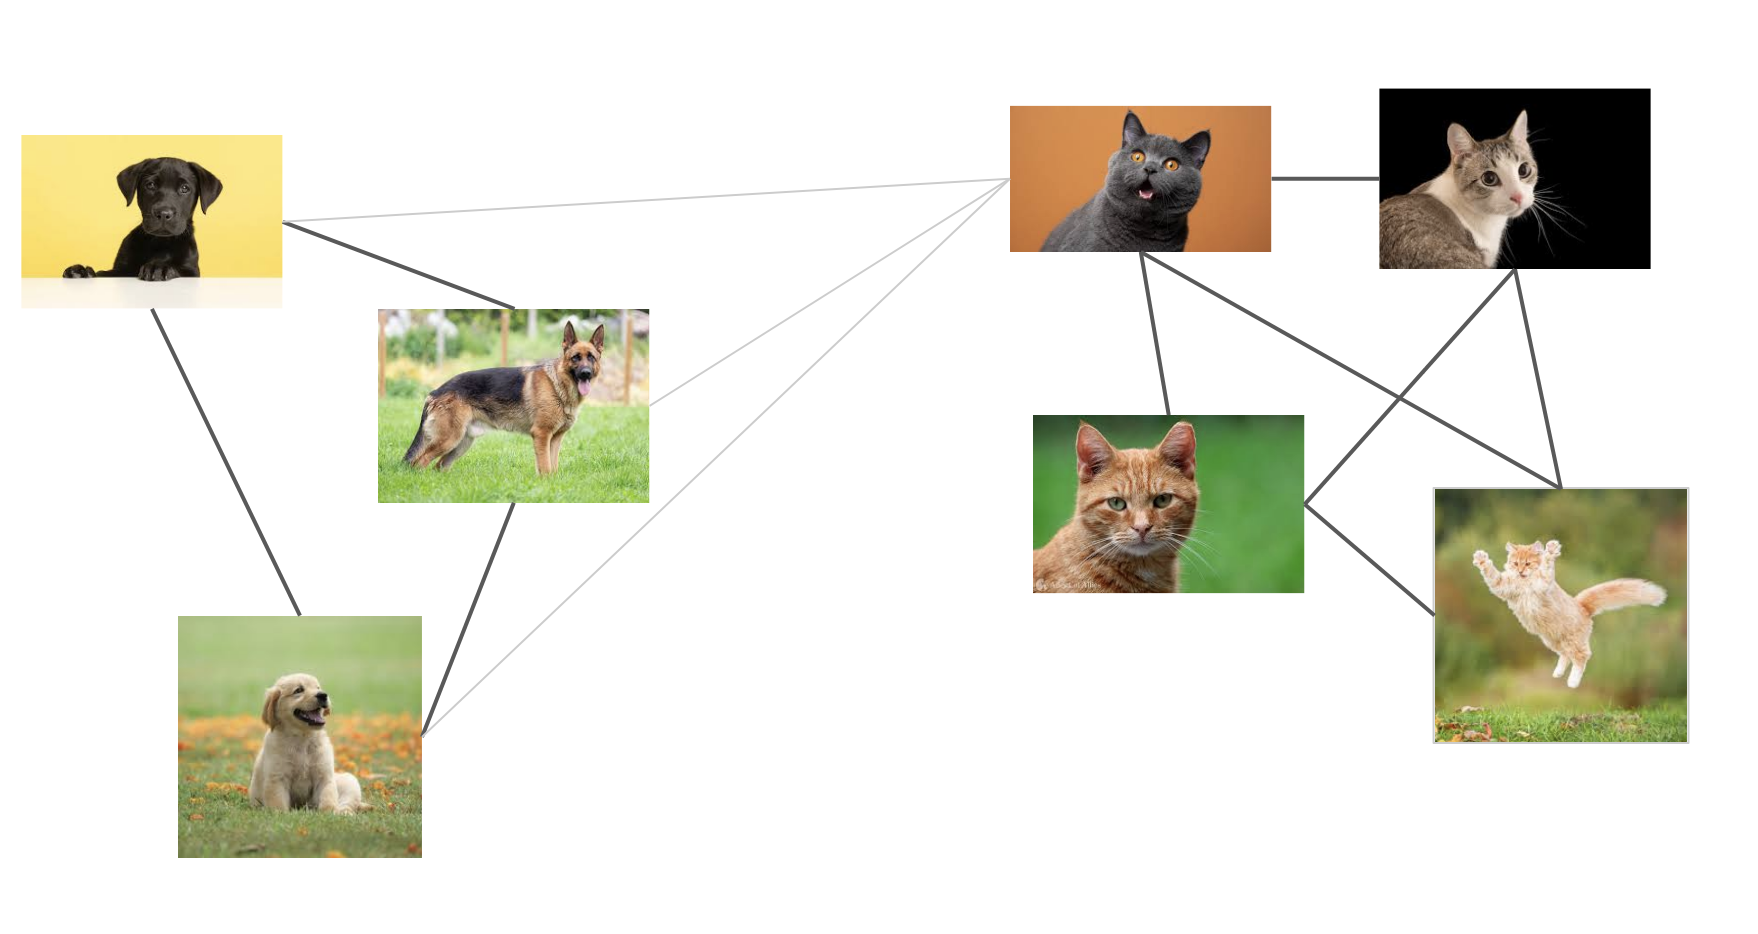

In [41]:
Image.open(os.path.join(ASSETS_DIR, 'demo_graph_cat_dog.png'))

## We can also use the same approach for a single image:

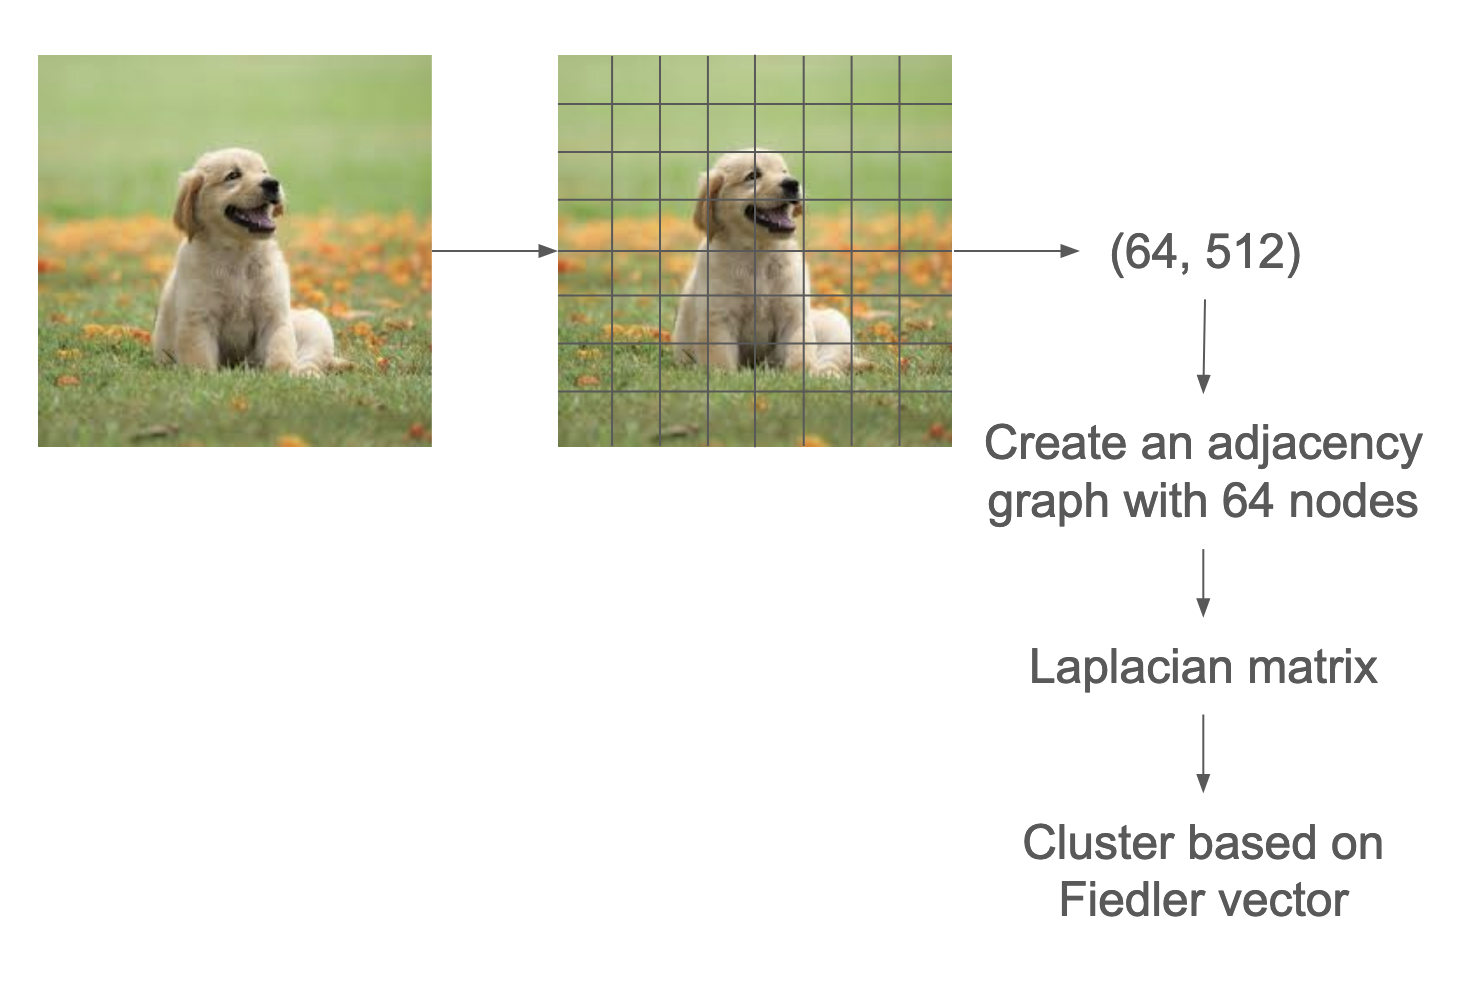

In [42]:
Image.open(os.path.join(ASSETS_DIR, 'demo_on_single_image.png'))

In [43]:
coco_images = glob(os.path.join(ASSETS_DIR, 'coco*'))
len(coco_images)

7

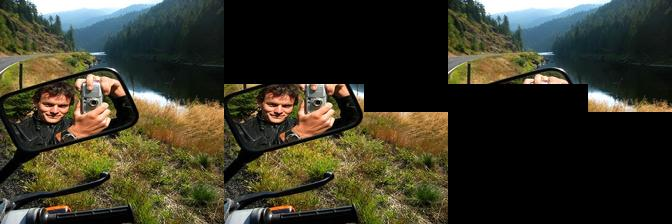

In [44]:
Image.open(coco_images[0])

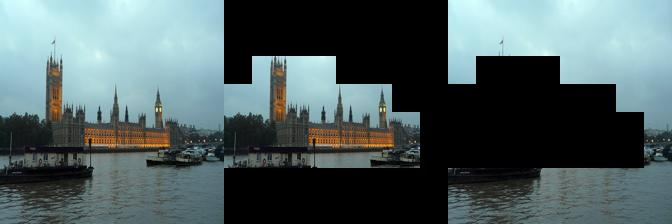

In [45]:
Image.open(coco_images[1])

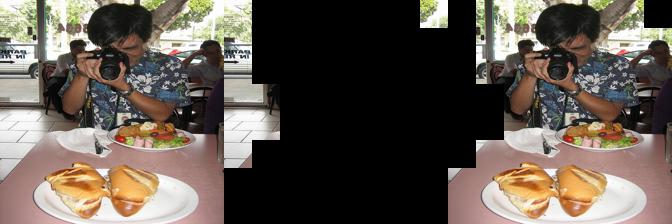

In [46]:
Image.open(coco_images[2])

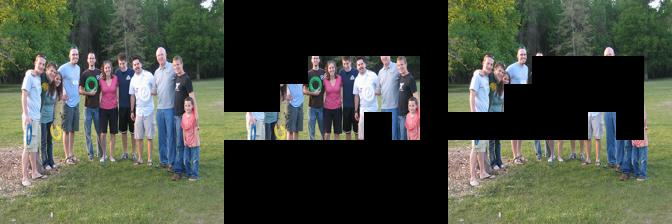

In [47]:
Image.open(coco_images[3])

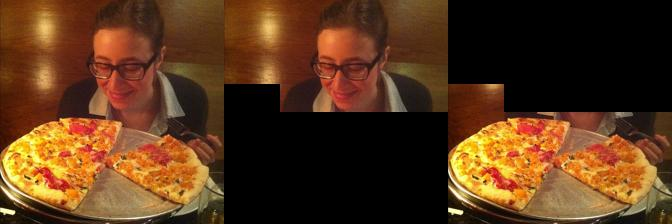

In [48]:
Image.open(coco_images[4])

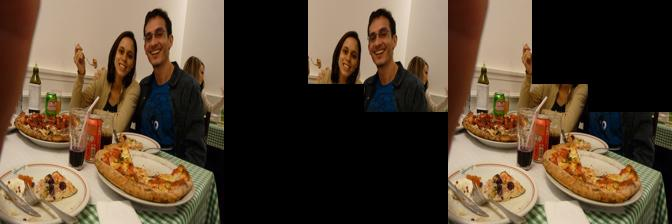

In [49]:
Image.open(coco_images[5])

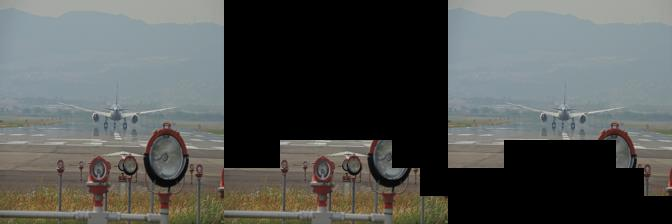

In [50]:
Image.open(coco_images[6])

### This leads to the idea of segmentation - separating the patches which belong to the background from the patches which belong to the foreground.